# DQN with Atari Pong using TF-Agents
Reference: https://github.com/jeffheaton/t81_558_deep_learning/blob/569ed623cb225a5d410fda6f49e1a15073b247ea/t81_558_class_12_04_atari.ipynb

In [1]:
# Bit of formatting because inline code is not styled very good by default:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

In [2]:
# Get necessary libraries
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym, suite_atari
from tf_agents.environments import tf_py_environment, batched_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

tf.compat.v1.enable_v2_behavior()

## Step 1: Create Environment from OpenAI Gym

In [3]:
env_name = 'Pong-v0'
ATARI_FRAME_SKIP = 4
max_episode_frames=108000

env = suite_atari.load(
        env_name,
        max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
        gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

env.reset()
#PIL.Image.fromarray(env.render())

print("Action space: ", env.action_space.n)
print("Observation space: ", env.observation_space)

Action space:  6
Observation space:  Box(84, 84, 4)


## Step 2: Convert Environment to Tensors

In [4]:
train_py_env = suite_atari.load(
                env_name,
                max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
                gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)
eval_py_env = suite_atari.load(
                env_name,
                max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
                gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Step 3: Set Hyperparameters

In [5]:
num_iterations = 150000 

initial_collect_steps = 1000 
collect_steps_per_iteration = 2  
replay_buffer_max_length = 100000 

batch_size = 32  
learning_rate = 1e-3  
log_interval = 1000  

num_eval_episodes = 10  
eval_interval = 5000  

## Step 4: Define Q Network

In [6]:
class AtariQNetwork(q_network.QNetwork):
  """QNetwork subclass that divides observations by 255."""

  def call(self,
           observation,
           step_type=None,
           network_state=(),
           training=False):
    state = tf.cast(observation, tf.float32)
    # We divide the grayscale pixel values by 255 here rather than storing
    # normalized values beause uint8s are 4x cheaper to store than float32s.
    state = state / 255
    return super(AtariQNetwork, self).call(
        state, step_type=step_type, network_state=network_state,
        training=training)

fc_layer_params = (512,125,)
conv_layer_params=((32, (8, 8), 4), (64, (4, 4), 2), (64, (2, 2), 1))

q_net = AtariQNetwork(
            train_env.observation_spec(),
            train_env.action_spec(),
            conv_layer_params=conv_layer_params,
            fc_layer_params=fc_layer_params)

## Step 5: Initialize Agent

In [7]:
optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

target_update_period=32000  
update_period=16 
_update_period = update_period / ATARI_FRAME_SKIP

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    gamma=0.95,
    epsilon_greedy=0.01,
    td_errors_loss_fn=common.element_wise_huber_loss,
    train_step_counter=train_step_counter,
    target_update_period=(
        target_update_period / ATARI_FRAME_SKIP / _update_period))

agent.initialize()

### Notes on Policies
Agents contain two policies: 

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.

To get an action from a policy, call the `policy.action(time_step)` method. The `time_step` contains the observation from the environment. This method returns a `PolicyStep`, which is a named tuple with three components:

-   `action` — the action to be taken (in this case, `0` or `1`)
-   `state` — used for stateful (that is, RNN-based) policies
-   `info` — auxiliary data, such as log probabilities of actions

In [8]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

## Step 6: Metrics and Evaluation

In [9]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [10]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-20.8

## Step 7: Replay Buffer

In [11]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

## Step 8: Data Collection

In [12]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=initial_collect_steps)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

## Step 9: Train Agent

In [13]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 1000: loss = 0.006223066709935665
step = 2000: loss = 0.010176085866987705
step = 3000: loss = 0.002247529337182641
step = 4000: loss = 0.01686147227883339
step = 5000: loss = 0.008872459642589092
step = 5000: Average Return = -21.0
step = 6000: loss = 0.0024638704489916563
step = 7000: loss = 0.024898001924157143
step = 8000: loss = 0.0030870491173118353
step = 9000: loss = 0.006516779772937298
step = 10000: loss = 0.013127190992236137
step = 10000: Average Return = -20.200000762939453
step = 11000: loss = 0.003686400828883052
step = 12000: loss = 0.0038947537541389465
step = 13000: loss = 0.0038205140735954046
step = 14000: loss = 0.0037984545342624187
step = 15000: loss = 0.013779914006590843
step = 15000: Average Return = -18.899999618530273
step = 16000: loss = 0.010277222841978073
step = 17000: loss = 0.005939126014709473
step = 18000: loss = 0.0016390940872952342
step = 19000: loss = 0.007438940461724997
step = 20000: loss = 0.01720503531396389
step = 20000: Average Retur

## Step 10: Visualize

(-21.375, -12.0)

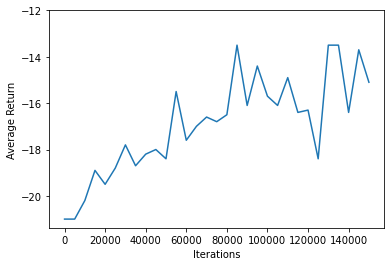

In [18]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=-12)

In [15]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="160" height="224" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=3, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)


create_policy_eval_video(agent.policy, "trained-agent")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [16]:
create_policy_eval_video(random_policy, "random-agent")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
